## IF867 - Introdução à Aprendizagem Profunda
### 2ª atividade prática

Discentes:
- João Pedro Campos de Medeiros
- Nathalia Fernanda de Araújo Barbosa

Período: 9º

## Instruções e Requisitos
- Objetivo: Construir e Explorar Redes Neurais Convolucionais (CNNs)
- Descrição: Esta tarefa tem como foco a construção de uma arquitetura CNN personalizada do zero, usando PyTorch ou biblioteca similar, e a experimentação com modelos pré-treinados, utilizando transfer-learning. Para treinamento e avaliação dos modelos, utilize o dataset [MNIST](https://pytorch.org/vision/0.20/generated/torchvision.datasets.MNIST.html#mnist). **Recomendamos** o uso de [PyTorch](https://pytorch.org).

### Requisitos para Entrega

- Código:
  - Implementação completa em um **Jupyter Notebook**.

- Resultados e Visualizações:
  - Gráficos das curvas de acurácia e perda para treinamento e validação, de ambos os modelos.
  - Visualizações dos mapas de características e insights gerados pelas ferramentas de explicação visual (caso tenha usado).

- Relatório:
  - Um breve relatório (pelo menos 10 linhas) comparando o desempenho da CNN personalizada e do modelo pré-treinado.
  - O relatório pode ser apenas um bloco de texto no Jupyter descrevendo os resultados.
  - Análise dos experimentos realizados e insights gerados.


### Referências

- [GradCAM](https://github.com/jacobgil/pytorch-grad-cam)
- [Optuna](https://optuna.org/)
- [PyTorch Vision Hub](https://pytorch.org/hub/pytorch_vision_vgg/)


# 1. Implementação própria(50%):
- Construa sua própria arquitetura CNN.

- Implemente funções genéricas para treinamento e avaliação, que possam ser reutilizadas em todos os modelos.

- Registre e organize o desempenho do modelo, incluindo:
  - Tempo de treinamento.
  - Matriz de confusão.
  - Gráficos de perda e acurácia.

In [2]:
# Import das bibliotecas
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import time

In [3]:
# Carrega o dataset MNIST sem transformações
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Empilha todas as imagens para calcular estatísticas
data = torch.cat([img.unsqueeze(0) for img, _ in dataset], dim=0)

# Calcula a média e o desvio padrão
mean = data.mean()
std = data.std()

print(f"Média: {mean.item():.4f}, Desvio Padrão: {std.item():.4f}")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 37.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.16MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.90MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Média: 0.1307, Desvio Padrão: 0.3081


In [4]:
# Configurações gerais
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformação dos dados aplicadas às imagens do dataset MNIST antes de serem passadas para a rede neural
transform = transforms.Compose([
    transforms.ToTensor(), # Converte a imagem PIL para um tensor do PyTorch e normaliza os valores de pixel para o intervalo [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Normaliza os dados usando a média e o desvio padrão do conjunto MNIST
])

# Carregamento do dataset
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Definição da CNN

### Estrutura da Rede
A CNN é composta por:  
- **2 Camadas Convolucionais** (`conv1` e `conv2`) – Extraem características da imagem usando filtros 3x3.  
- **2 Camadas Totalmente Conectadas** (`fc1` e `fc2`) – Interpretam as características e classificam os dígitos.  
- **Função de Ativação ReLU** – Introduz não-linearidade para melhorar o aprendizado.  
- **Camada de Pooling MaxPool2d** – Reduz a dimensionalidade, tornando a rede mais eficiente.  
- **Dropout para regularização** – Previne overfitting ao desativar neurônios aleatoriamente durante o treinamento.

O método `forward` define como os dados passam pela rede durante a inferência e o treinamento.  

1. **Primeira Convolução** → `conv1(x)`  
   - Extrai características iniciais da imagem.  
   - Aplica **ReLU** para ativação.  
   - Aplica **MaxPooling** para reduzir a dimensão.  

2. **Segunda Convolução** → `conv2(x)`  
   - Extrai características mais profundas.  
   - Aplica **ReLU** e **MaxPooling** novamente.  

3. **Flatten (`view`)**  
   - Transforma os mapas de características 2D em um vetor 1D para as camadas totalmente conectadas.  

4. **Primeira Camada Totalmente Conectada** → `fc1(x)`  
   - Reduz para 128 neurônios e aplica **ReLU**.  

5. **Dropout** → `dropout(x)`  
   - Previne overfitting ao desativar 50% dos neurônios.  

6. **Saída Final** → `fc2(x)`  
   - Gera **10 logits**, um para cada classe (dígitos de 0 a 9).

In [5]:
# Definição da CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### Treinamento e Avaliação

In [6]:
# Função de treino
def train_model(model, criterion, optimizer, train_loader, epochs=10):
    model.train()
    train_losses = []
    start_time = time.time()
    for epoch in range(epochs):
        #print(f"Epoch: {epoch}")
        running_loss = 0.0
        #counter = 1
        for images, labels in train_loader:
            #print(f"Counter do for do train_loader: {counter}")
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            #counter = counter + 1
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Época {epoch+1}/{epochs}, Perda: {avg_loss:.4f}")
    total_time = time.time() - start_time
    print(f"Tempo total de treinamento: {total_time:.2f} segundos")
    return train_losses

# Função de avaliação
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = 100 * correct / total
    print(f"Acurácia no conjunto de teste: {accuracy:.2f}%")
    return all_labels, all_preds

In [ ]:
# Treinamento e avaliação
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = train_model(model, criterion, optimizer, train_loader, epochs=10)
labels, preds = evaluate_model(model, test_loader)

Época 1/10, Perda: 0.2012
Época 2/10, Perda: 0.0759
Época 3/10, Perda: 0.0561
Época 4/10, Perda: 0.0470
Época 5/10, Perda: 0.0384
Época 6/10, Perda: 0.0320
Época 7/10, Perda: 0.0284
Época 8/10, Perda: 0.0266
Época 9/10, Perda: 0.0232
Época 10/10, Perda: 0.0205
Tempo total de treinamento: 985.22 segundos
Acurácia no conjunto de teste: 99.24%


### Gráficos

In [ ]:
def plot_training_results(labels, preds, train_losses):
    # Plotando a matriz de confusão
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

    # Gráfico de perda
    plt.figure(figsize=(8,6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Perda", marker='o')  # Começa na época 1
    plt.xlabel("Época")
    plt.ylabel("Perda")
    plt.xticks(ticks=range(1, len(train_losses) + 1))  # Ajusta os ticks do eixo x
    plt.title("Evolução da Perda Durante o Treinamento")
    plt.legend()
    plt.grid()
    plt.show()

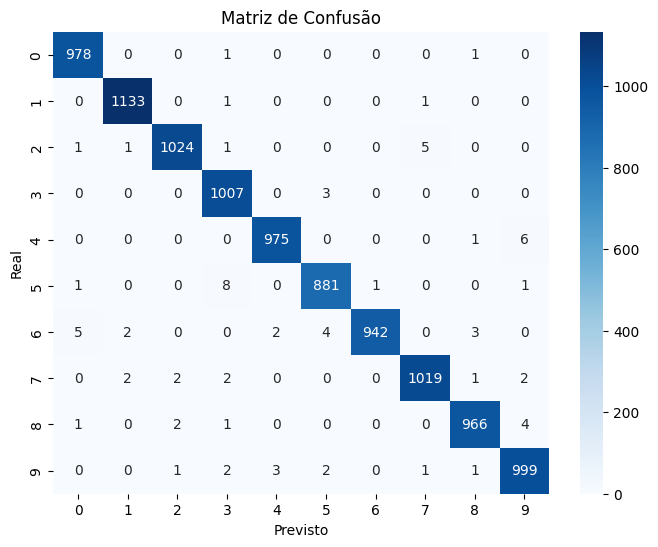

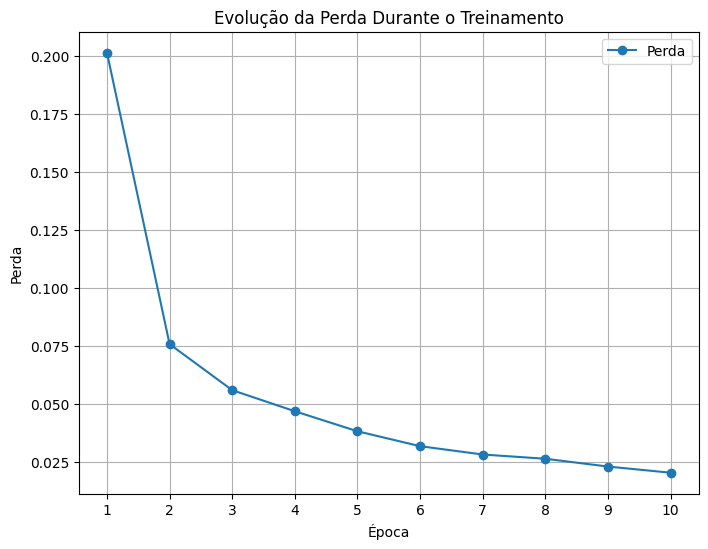

In [ ]:
plot_training_results(labels, preds, train_losses)

# 2. __Modelo(s) pré-treinado(s) (30%):__
- Selecione um modelo pré-treinado para realizar transfer learning.
  - Recomendação: PyTorch Vision Hub.
- Ajuste o modelo pré-treinado para o dataset escolhido (MNIST).

O dataset MNIST contém imagens em escala de cinza com tamanho 28×28, enquanto a AlexNet foi projetada para receber imagens coloridas (RGB) de 224×224 pixels. Portanto, antes de alimentar as imagens na rede, algumas transformações são necessárias:

- Converter imagens de um canal (escala de cinza) para três canais (RGB).  
- Redimensionar as imagens para 256×256 e aplicar um recorte central para 224×224.  
- Normalizar os valores de pixel com a média e o desvio padrão do MNIST.  

Após carregar os conjuntos de treino e teste do MNIST, o modelo AlexNet pré-treinado no ImageNet é carregado. No entanto, como essa rede foi projetada para classificar 1000 classes e o MNIST possui apenas 10 (dígitos de 0 a 9), a camada final precisa ser ajustada.  

A camada de entrada da AlexNet não precisa ser modificada, pois a conversão de um para três canais já foi feita na etapa de pré-processamento. Assim, a primeira camada convolucional do modelo (`conv1`) permanece inalterada, com as seguintes características:  

- Entrada: 3 canais (RGB).  
- Saída: 96 mapas de características.  
- Filtro de tamanho 11×11.  
- Stride de 4, reduzindo a resolução da imagem.  
- Padding de 2, preservando um tamanho adequado na saída.  
- Uso de termo de bias, pois a AlexNet original inclui esse parâmetro.  

Já a última camada da AlexNet, originalmente composta por 1000 neurônios (devido ao treinamento no ImageNet), precisa ser substituída para adequar-se ao MNIST. No código, essa substituição é feita da seguinte forma:  

- `model.classifier[6].in_features` obtém o número de entradas na última camada da AlexNet.  
- `nn.Linear(num_ftrs, 10)` cria uma nova camada totalmente conectada com 10 neurônios de saída, correspondendo às classes do MNIST.  

Essa modificação permite que a rede retorne 10 probabilidades, ajustando o modelo ao novo problema de classificação.

In [ ]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformação dos dados para o formato exigido pelo AlexNet
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Converter MNIST para 3 canais (RGB)
    transforms.Resize(256),  # Ajustar para o tamanho esperado pelo modelo
    transforms.CenterCrop(224),  # Cortar no centro para 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307] * 3, std=[0.3081] * 3),
])

# Carregamento do dataset MNIST com as transformações
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Carregar o modelo pré-treinado AlexNet
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Congelar todas as camadas iniciais
for param in model.parameters():
    param.requires_grad = False

# Ajustar a última camada para 10 classes (MNIST tem 10 classes)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)

# Garantir que apenas a última camada será treinada
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Mover o modelo para o dispositivo (GPU ou CPU)
model = model.to(device)

# Configuração do treinamento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.35MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 130MB/s]


In [ ]:
# Treinar e avaliar
train_losses = train_model(model, criterion, optimizer, train_loader, epochs=10)
labels, preds = evaluate_model(model, test_loader)

Época 1/10, Perda: 0.3935
Época 2/10, Perda: 0.2919
Época 3/10, Perda: 0.2747
Época 4/10, Perda: 0.2677
Época 5/10, Perda: 0.2593
Época 6/10, Perda: 0.2639
Época 7/10, Perda: 0.2553
Época 8/10, Perda: 0.2602
Época 9/10, Perda: 0.2547
Época 10/10, Perda: 0.2535
Tempo total de treinamento: 22531.63 segundos
Acurácia no conjunto de teste: 96.23%


- Compare o desempenho da sua CNN personalizada com o modelo pré-treinado, analisando:
  - Tempo de treinamento (mostrado acima).
  - Acurácia (mostrado acima).
  - Outras métricas relevantes.

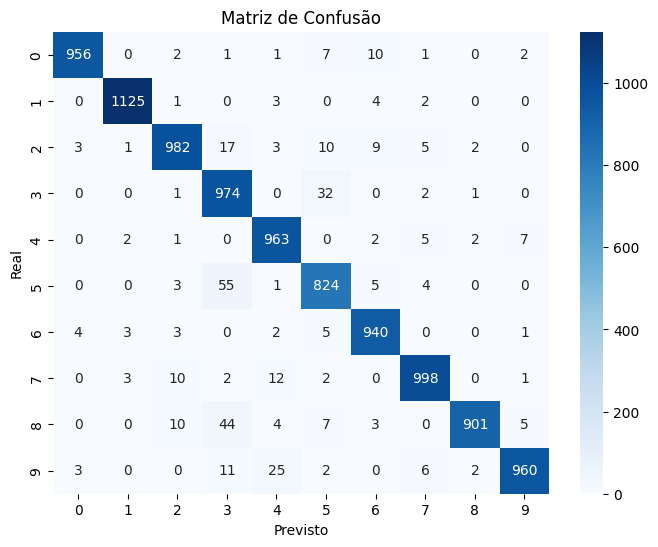

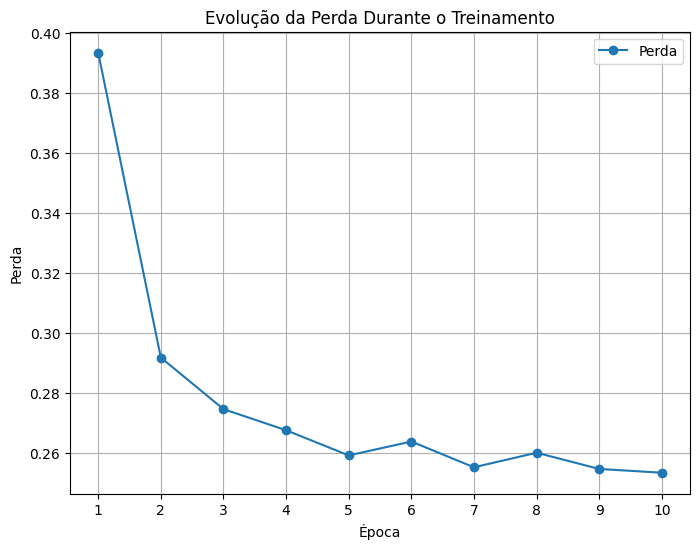

In [ ]:
plot_training_results(labels, preds, train_losses)

A comparação entre a CNN personalizada e o modelo pré-treinado AlexNet revelou diferenças significativas em tempo de treinamento, acurácia e eficiência na convergência da perda. A CNN personalizada treinou em apenas **985,22 segundos (~16 minutos)**, enquanto a AlexNet levou **22.531,63 segundos (~6,25 horas)**, tornando o modelo pré-treinado **22,9 vezes mais lento**. Esse alto custo computacional da AlexNet ocorre porque ela foi projetada para processar imagens complexas do ImageNet, contendo milhões de parâmetros, o que não é ideal para um dataset simples como o MNIST.

Além disso, a CNN personalizada obteve uma acurácia de **99,24%**, superando os **96,23%** do modelo pré-treinado. A análise da convergência da perda reforça essa vantagem: a CNN personalizada iniciou com uma perda de **0.2012** e terminou com **0.0205**, apresentando uma queda rápida e estabilizando cedo. Já a AlexNet começou com **0.3935** e terminou em **0.2535**, mostrando uma redução mais lenta e menos eficiente ao longo das épocas.

Apesar do alto desempenho da CNN personalizada, a acurácia muito próxima de 100% sugere um possível **overfitting**. Como o MNIST é um dataset relativamente simples, uma rede profunda pode memorizar os padrões do conjunto de treino em vez de generalizar bem para dados novos. Para confirmar esse comportamento, seria necessário analisar a acurácia no conjunto de validação e verificar métricas como a perda de validação ao longo do treinamento. Caso o modelo apresente uma grande diferença entre a acurácia de treino e teste, técnicas como regularização L2, dropout e aumento de dados poderiam ser aplicadas para melhorar a generalização. Dessa forma, a CNN personalizada demonstrou ser a melhor escolha para a classificação de dígitos do MNIST, treinando muito mais rápido e com melhor desempenho. No entanto, a possibilidade de overfitting indica que ajustes adicionais podem ser necessários para garantir que o modelo generalize bem para novos exemplos.

# 3. __Experimentação (20%):__

Escolha ao menos um experimento de cada categoria abaixo:

- Desempenho dos Modelos:
  - Realize tuning de hiperparâmetros. Recomendação: Optuna.
  - Aplique técnicas de regularização (ex.: dropout, weight decay).

- Visualização:
  - Visualize os mapas de características (_feature maps_) das camadas convolucionais de sua CNN personalizada e compare com o modelo pré-treinado.
  - Utilize ferramentas de explicação visual, como _Grad-CAM_, para interpretar o comportamento dos modelos.

### Experimentação com regularizador L2

O Weight Decay, também conhecido como Regularização L2, é uma técnica utilizada para evitar overfitting penalizando pesos muito grandes na rede neural.

O valor 1e-4 define a intensidade da penalização. Valores muito altos podem dificultar o aprendizado, enquanto valores muito baixos podem não ser eficazes.

In [ ]:
# Treinamento e avaliação
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

train_losses = train_model(model, criterion, optimizer, train_loader, epochs=10)
labels, preds = evaluate_model(model, test_loader)

Época 1/10, Perda: 0.2131
Época 2/10, Perda: 0.0839
Época 3/10, Perda: 0.0647
Época 4/10, Perda: 0.0540
Época 5/10, Perda: 0.0456
Época 6/10, Perda: 0.0390
Época 7/10, Perda: 0.0359
Época 8/10, Perda: 0.0329
Época 9/10, Perda: 0.0291
Época 10/10, Perda: 0.0279
Tempo total de treinamento: 1169.06 segundos
Acurácia no conjunto de teste: 99.34%


### Visualização dos mapas de características das camadas convolucionais da CNN

#### CNN personalizada

Hooks foram adicionados às camadas convolucionais (conv1 e conv2) para capturar as ativações durante a inferência. Uma amostra do dataset foi passada pela rede e os feature maps das camadas iniciais foram extraídos. Os mapas de características foram exibidos usando matplotlib, mostrando quais padrões a rede estava detectando.

In [ ]:
# Registrar hooks para capturar feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
# Visualizar Feature Maps
def plot_feature_maps(activation, layer_name, num_maps=6):
    act = activation[layer_name].cpu().squeeze(0)
    fig, axes = plt.subplots(1, num_maps, figsize=(15, 5))
    for i in range(num_maps):
        axes[i].imshow(act[i].numpy(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Feature Maps da {layer_name}")
    plt.show()


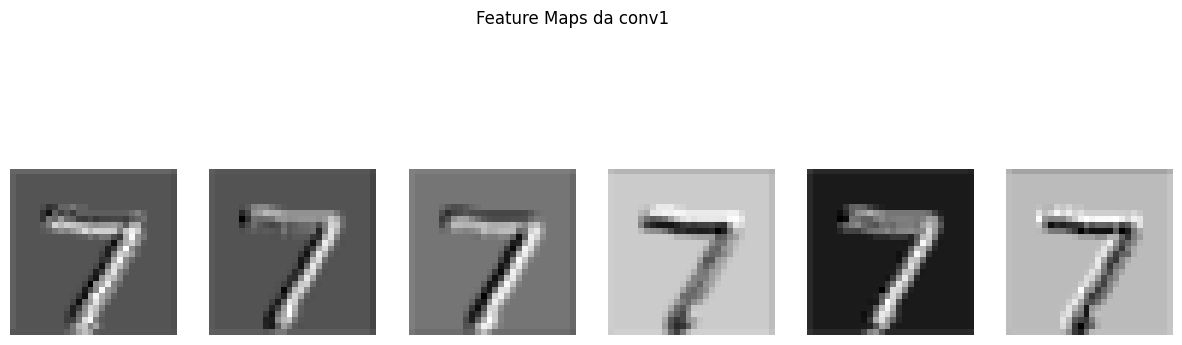

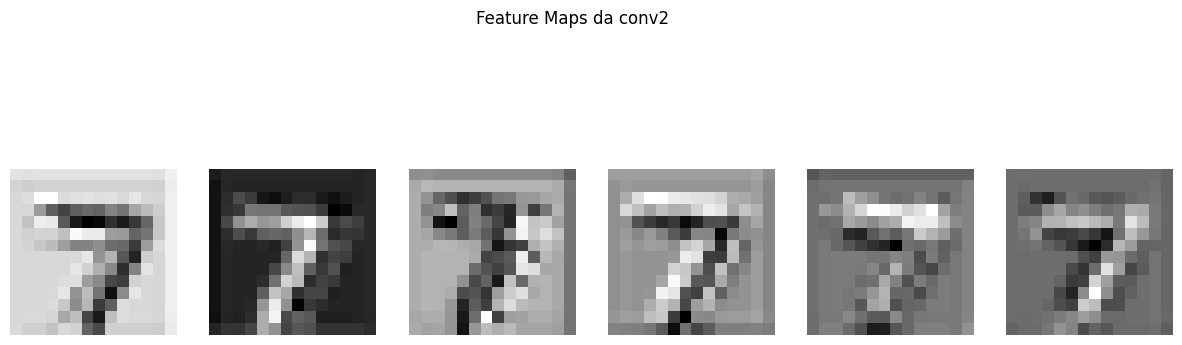

In [ ]:
model = CNN().to(device)

# Registrar os hooks nas camadas convolucionais
model.conv1.register_forward_hook(get_activation('conv1'))
model.conv2.register_forward_hook(get_activation('conv2'))

# Selecionar uma imagem do dataset de teste
dataiter = iter(test_loader)
images, _ = next(dataiter)
image = images[0].unsqueeze(0).to(device)  # Pegando uma única imagem

# Fazer forward na CNN
model(image)

# Plotar os feature maps das camadas convolucionais
plot_feature_maps(activation, 'conv1')
plot_feature_maps(activation, 'conv2')

#### CNN pré-treinada

Semelhantemente ao que foi feito no caso da CNN personalizada, adicionamos umm hook na primeira camada convolucional para capturar as ativações. Uma amostra do dataset foi passada pela rede e os feature maps da camada inicial foi extraído. Os mapas de caracterísitcas foram, asism como no caso da CNN personalizada, exibidos  utiliznado matplotlib.

In [7]:
# Registrar Hook para capturar feature maps da primeira camada convolucional
feature_maps = {}
def hook_fn(module, input, output):
    feature_maps["conv1"] = output.detach().cpu()

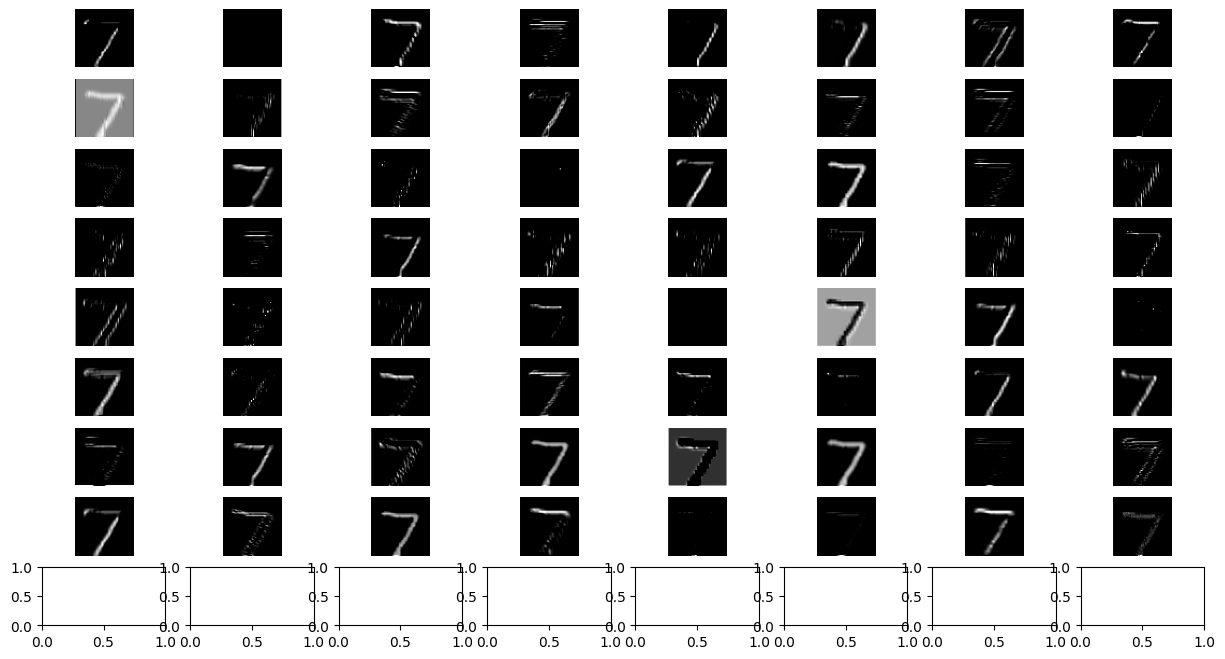

In [13]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformação dos dados para o formato exigido pelo AlexNet
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Converter MNIST para 3 canais (RGB)
    transforms.Resize(256),  # Ajustar para o tamanho esperado pelo modelo
    transforms.CenterCrop(224),  # Cortar no centro para 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307] * 3, std=[0.3081] * 3),
])

# Carregamento do dataset MNIST com as transformações
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Carregar o modelo pré-treinado AlexNet
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

# Mover o modelo para o dispositivo
torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Conectar o hook na primeira camada convolucional
model.features[0].register_forward_hook(hook_fn)

# Obter um batch do test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Escolher uma imagem do batch e passá-la pela rede
image = images[0].unsqueeze(0).to(device)  # Adicionar dimensão de batch
model(image)

# Obter os feature maps da primeira convolução
activation = feature_maps["conv1"].squeeze(0)  # Remover dimensão do batch

# Plotar os feature maps
num_features = activation.shape[0]
cols = 8
rows = num_features // cols + 1

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
for i, ax in enumerate(axes.flat):
    if i < num_features:
        ax.imshow(activation[i].numpy(), cmap="gray")
        ax.axis("off")

plt.show()

## 4. Conclusão

Nesta atividade, o objetivo era implementar uma CNN personalizada e compará-la com a CNN pré-treinada AlexNet. Durante as análises, observou-se que a CNN personalizada apresentou sinais de overfitting, evidenciado por uma alta acurácia no treinamento. Esse problema pode ser mitigado com o uso de técnicas como regularização. Além disso, a robustez do modelo AlexNet ficou evidente pelo tempo de treinamento, que se mostrou mais eficiente em comparação com a rede personalizada. Outro ponto analisado foi o número de outputs da rede personalizada em relação ao AlexNet, como ilustrado nas imagens, indicando que um maior número de outputs pode contribuir para uma extração de features mais detalhada.